In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.animation import FuncAnimation, ArtistAnimation
from scipy.constants import hbar
#from rydbperc.cython_utilities import util
from rydbperc import ryperc
from rydbperc import twoatoms
import numpy as np

absorbing state phase transition paper oliver: https://arxiv.org/pdf/1611.03288.pdf

In [54]:
def experiment(
        N_points = 5000,
        detuning_IR = 25, # detuning [MHz]
        dt = 1, # [us]
        evo_time = 1500, # [us]
        power_blue = 1.5e-3,
        waste_blue = 40e-6,
        power_IR = 40e-3,
        waste_IR = 100e-6,
        detuning_blue = 400,
        p_facilitation = 0,
        shape = [80,80,80], # shape MOT in microns
        repetitions = 10
        ):
    if detuning_IR == 0:
        detuning_IR = 0.001

    text = "simulation parameters:\n"
    text += "detuning from Rydberg = %.1f \n"%detuning_IR

    C6 = 0.870 *10**6
    gamma_def = 4.4 # [MHz]
    radius_shell = (C6/(detuning_IR))**(1/6)
    delta_radius_shell = radius_shell*(gamma_def/(6*detuning_IR))

    text += "facilitation shell radius and delta = %.1f +- %.4f \n" %(radius_shell,delta_radius_shell/2)

    N_steps = int(evo_time/dt)

    atom = twoatoms.single_atom(power_blue, waste_blue, power_IR, waste_IR, detuning_blue, detuning_IR=detuning_IR)#, power_depumping=10e-3, waste_depumping=100e-6)
    rho0 = np.zeros([4,4])
    rho0[0,0] = 1
    steps = 10000
    time = 10 # us
    atom.evolve(time, steps, rho0)
    
    text += "two photon rabi freq. = %.3f MHz\n"%atom.two_photon_rabi_freq

    radius_blokade = atom.radius_blokade
    text += "blokade radius = %.1f um\n" %(atom.radius_blokade)
    text += "number of steps = %d \n"%N_steps

    p_spont_exc = atom.get_excitation_probability()*dt/time
    p_spont_emi = atom.Gamma_70s * dt

    text += "probabiliy of one atom in one step of:\n"
    text += " . spontaneous excitation  = %.6f \n"%(p_spont_exc)
    text += " . spontaneous emission = %.6f \n"%p_spont_emi
    text += " . facilitated excitation = %.6f \n"%p_facilitation

    density = N_points/(shape[0]*shape[1]*shape[2]*10**-2) # atoms/cm^3

    text += "mean density = %.1f 10^10\n"%density
    
    excs = []
    fac_excs = []
    for _ in range(repetitions):
        clear_output(wait=True)
        print(text, "status: %.1f %%"%_)
        clu = ryperc.cluster3D(N_points, shape, distribution="gaussian", MOT_radius=shape[0]/4, is_2D=True)

        clu.set_evolution_parameters(
                                    shell_radius=radius_shell, 
                                    shell_delta=delta_radius_shell, 
                                    blokade_radius=radius_blokade,
                                    p_spont_exct=p_spont_exc, 
                                    p_emission=p_spont_emi, 
                                    p_fac=p_facilitation
                                    )
        exc, fac_exc = clu.evolve(N_steps, excitation_steps=int(N_steps/100))
        excs.append(exc)
        fac_excs.append(fac_exc)

        clu.show()
        plt.show()
    return np.mean(excs, axis=0), np.std(excs, axis=0), np.mean(fac_excs, axis=0), np.std(fac_excs, axis=0)

simulation parameters:
detuning from Rydberg = 20.0 
facilitation shell radius and delta = 5.9 +- 0.1087 
two photon rabi freq. = 0.309 MHz
blokade radius = 11.9 um
number of steps = 1000 
probabiliy of one atom in one step of:
 . spontaneous excitation  = 0.000599 
 . spontaneous emission = 0.026698 
 . facilitated excitation = 0.500000 
mean density = 0.2 10^10
 status: 3.0 %


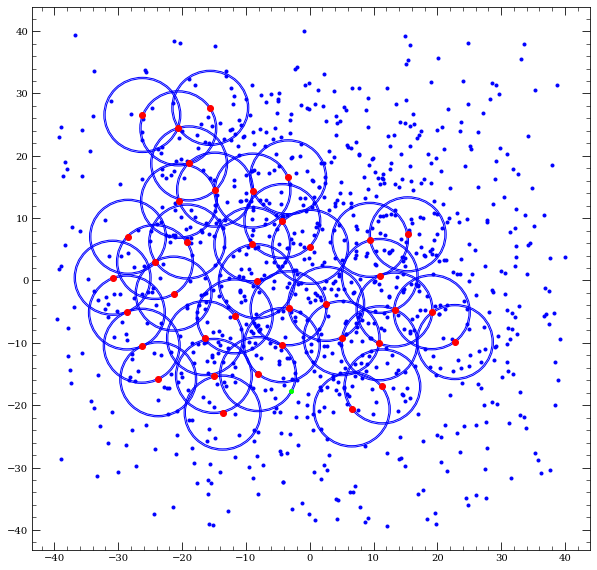

In [61]:
evo_time = 10000
dt = 10

res, std_res, fac_res, std_fac_res = experiment(
        N_points = 1000,
        detuning_IR = 20, # detuning [MHz]
        dt = dt, # [us]
        evo_time = evo_time, # [us]
        power_blue = 1.5e-3,
        waste_blue = 40e-6,
        power_IR = 40e-3,
        waste_IR = 100e-6,
        detuning_blue = 400,
        p_facilitation = 0.5,
        shape = [80,80,80], # shape MOT in microns
        repetitions = 4
        )


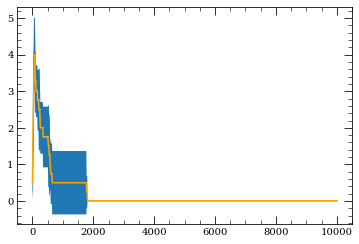

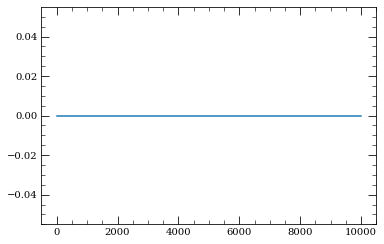

In [56]:
x = np.linspace(0, evo_time, len(res))
plt.fill_between(x, res-std_res, res+std_res)
plt.plot(x, res, color="orange", marker=",")
plt.show()

plt.plot(x, fac_res)
plt.show()

simulation parameters:
detuning from Rydberg = 20.0 
facilitation shell radius and delta = 5.9 +- 0.1087 
two photon rabi freq. = 0.309 MHz
blokade radius = 11.9 um
number of steps = 1000 
probabiliy of one atom in one step of:
 . spontaneous excitation  = 0.000599 
 . spontaneous emission = 0.026698 
 . facilitated excitation = 0.080000 
mean density = 0.2 10^10
 status: 29.0 %


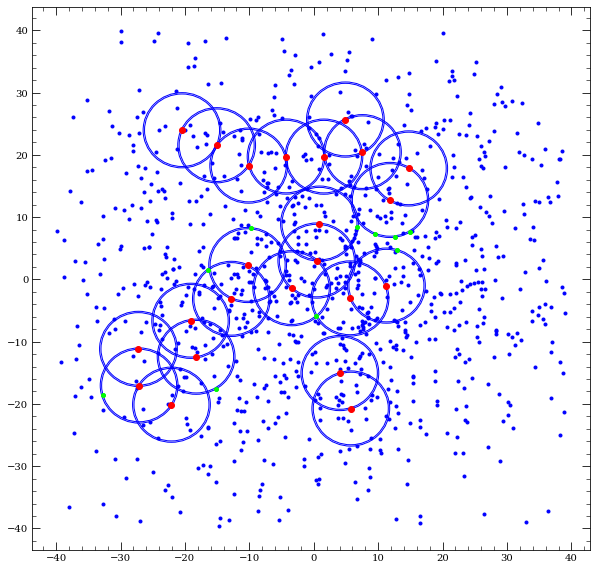

0.08


In [65]:

res1 = []
res_std1 = []
p_facs = np.linspace(0,0.08, 10)
for p_facilitation in p_facs:

    evo_time = 10000
    dt = 10

    res, std_res, fac_res, std_fac_res = experiment(
            N_points = 1000,
            detuning_IR = 20, # detuning [MHz]
            dt = dt, # [us]
            evo_time = evo_time, # [us]
            power_blue = 1.5e-3,
            waste_blue = 40e-6,
            power_IR = 40e-3,
            waste_IR = 100e-6,
            detuning_blue = 400,
            p_facilitation = p_facilitation,
            shape = [80,80,80], # shape MOT in microns
            repetitions = 30
            )

    res1.append(res[-1])
    res_std1.append(std_res[-1])
        
    print(p_facilitation)

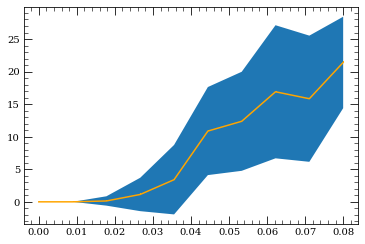

In [67]:

plt.fill_between(p_facs, np.array(res1)-np.array(res_std1), np.array(res1)+np.array(res_std1))
plt.plot(p_facs, res1, color="orange", marker=",")
plt.show()

simulation parameters:
detuning from Rydberg = 20.0 
facilitation shell radius and delta = 5.9 +- 0.1087 
two photon rabi freq. = 0.309 MHz
blokade radius = 11.9 um
number of steps = 1000 
probabiliy of one atom in one step of:
 . spontaneous excitation  = 0.000599 
 . spontaneous emission = 0.026698 
 . facilitated excitation = 0.080000 
mean density = 2.9 10^10
 status: 0.0 %


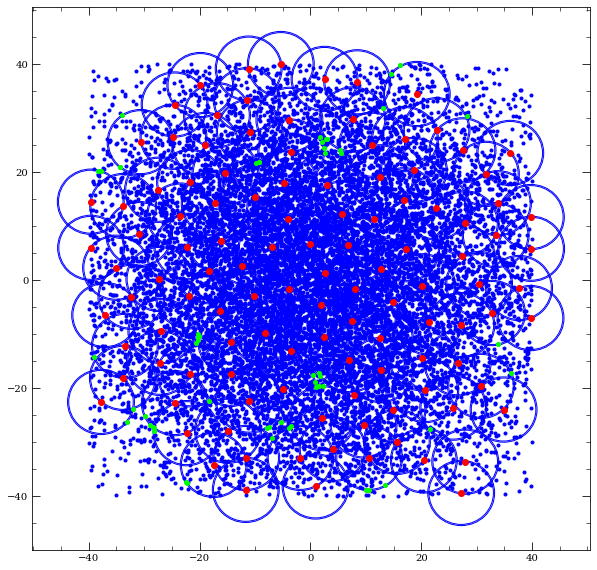

(array([ 17.,  31.,  39.,  54.,  58.,  62.,  69.,  74.,  80.,  84.,  90.,
         94.,  97.,  99., 103., 105., 104., 106., 107., 104., 106., 110.,
        111., 108., 109., 108., 108., 108., 109., 108., 107., 111., 113.,
        114., 117., 115., 116., 115., 117., 117., 117., 118., 118., 118.,
        119., 118., 117., 115., 114., 112., 110., 110., 111., 111., 108.,
        106., 107., 115., 113., 112., 114., 113., 112., 113., 122., 121.,
        120., 118., 120., 122., 122., 121., 119., 113., 115., 114., 113.,
        114., 114., 115., 118., 118., 119., 120., 119., 118., 115., 114.,
        113., 112., 111., 113., 116., 113., 115., 113., 115., 116., 115.,
        115., 116., 112., 112., 114., 111., 114., 115., 113., 115., 117.,
        113., 115., 116., 115., 116., 115., 117., 114., 112., 111., 109.,
        107., 109., 112., 113., 112., 113., 112., 114., 115., 118., 115.,
        117., 117., 116., 117., 117., 114., 121., 116., 113., 106., 103.,
        111., 111., 110., 112., 114., 

In [68]:
experiment(
            N_points = 15000,
            detuning_IR = 20, # detuning [MHz]
            dt = dt, # [us]
            evo_time = evo_time, # [us]
            power_blue = 1.5e-3,
            waste_blue = 40e-6,
            power_IR = 40e-3,
            waste_IR = 100e-6,
            detuning_blue = 400,
            p_facilitation = p_facilitation,
            shape = [80,80,80], # shape MOT in microns
            repetitions = 1
            )